# Image Embeddings Projection

In this notebook, we shall take a group of images, perform an embedding analysis using the [Distant Viewing Toolkit](https://github.com/distant-viewing/dvt), and then project this data into a 2 dimensional space. This is then exported as an annotated IIIF Manifest that can be opened in Arvest, rendering an interface very similar to [PixPlot](https://dhlab.yale.edu/projects/pixplot/).

## 1. Setup

First, we need to install and import the various packages that we shall be using.

In [1]:
!pip install -q git+https://github.com/jdchart/millefeuille-api.git
!pip install -q git+https://github.com/distant-viewing/dvt.git
!mkdir -p /root/.cache/torch/hub/checkpoints/

import mfapi
import dvt
import requests
import json
import random
import os
import numpy as np
from io import BytesIO
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.2 MB/s eta 0:00:00


## 2. Get Media

Next we need to find the media that we wish to use. Here, we assume that you have already uploaded your media to Millefeuille as a IIIF Manifest. If this is not the case, please follow the tutorials for adding media.

Let's make a list of IIIF Manifest urls that we wish to treat. We shall be using 500 fsa color example images. We have already created the Manifests which are stocked on our server. This JSON file simply gives a list of these urls:

In [2]:
manifest_list_data = "https://files.tetras-libre.fr/other/fsa_manifest_paths.json"

response = requests.get(manifest_list_data)
if response.status_code == 200:
    manifest_list = json.loads(response.text)["manifests"]

print(manifest_list)

['https://files.tetras-libre.fr/manifests/fsa_color/1a34898v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34820v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34865v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34653v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34978v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34183v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34552v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a33879v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a35207v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34207v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34242v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34945v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34106v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a34143v.json', 'https://files.tetras-libre.fr/manifests/fsa_color/1a33921v.j

## 3. Create embeddings

Now we can use the distant viewing toolkit to perform an embedding analysis on these images.

In [3]:
embedder = dvt.AnnoEmbed()

for i, manifest in enumerate(manifest_list[:20]):
  print(f"Treating {manifest} ({i + 1}/{len(manifest_list[:20])})...")

  media_as_np = mfapi.read_manifest(manifest).media_to_np()
  embedding = embedder.run(media_as_np)["embedding"]

  if i == 0:
    embedding_list = embedding
  else:
    embedding_list = np.vstack((embedding_list, embedding))

print(embedding_list)

Downloading: "https://github.com/distant-viewing/dvt/releases/download/0.0.1/dvt_embed.pt" to /root/.cache/torch/hub/checkpoints/dvt_embed.pt
100%|██████████| 83.6M/83.6M [00:00<00:00, 151MB/s]


Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34898v.json (1/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34820v.json (2/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34865v.json (3/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34653v.json (4/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34978v.json (5/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34183v.json (6/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34552v.json (7/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a33879v.json (8/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a35207v.json (9/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34207v.json (10/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34242v.json (11/20)...
Treating https://files.tetras-libre.fr/manifests/fsa_color/1a34945v.json (12/20)...
T

As you'll have noticed, this analysis is quite slow! Let's save the results just in case anything bad happens so that we can always start again from this point!

In [ ]:
np.save("embeddings.npy", embedding_list)
files.download("embeddings.npy")

## 4. Dimensionality Reduction

Now that we have our embedding data, we can use dimensionality reduction to crunch all of these dimensions down into 2 so that they can be projected into a 2-dimensional space. To do this, we'll use an algorithm called [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

First, use the following code if you are loading a previously saved embedding data file (note that you'll also have to run ll of the previous code cells except those in Section 3).

In [ ]:
embedding_list = np.load("embeddings.npy")

Now we can perform the diemsnionality reduction! Note that we also do some pre- and post-processing, the full process is: standardisation -> dimensionality reduction -> normalization.

In [4]:
standardized = StandardScaler().fit_transform(embedding_list)
reduced = TSNE(n_components = 2, perplexity=10).fit_transform(standardized)
normalized = MinMaxScaler((0, 1)).fit_transform(reduced)

print(normalized)

[[0.84734917 0.36129415]
 [0.4925885  0.474096  ]
 [0.25231963 0.35598046]
 [0.64860845 0.4478269 ]
 [0.19846678 0.20892647]
 [0.43995243 1.        ]
 [0.33883557 0.5904554 ]
 [0.02317119 0.78369725]
 [0.30113405 0.78161275]
 [0.51413864 0.6664607 ]
 [0.20209214 0.6669571 ]
 [0.8583169  0.54156375]
 [0.66144663 0.8637967 ]
 [0.45254764 0.7907752 ]
 [0.5191628  0.25022358]
 [1.         0.2944459 ]
 [0.3852691  0.        ]
 [0.8084588  0.15274912]
 [0.2079801  0.9567151 ]
 [0.         0.50514364]]


If we like, we can visualize the data in a scatter plot:

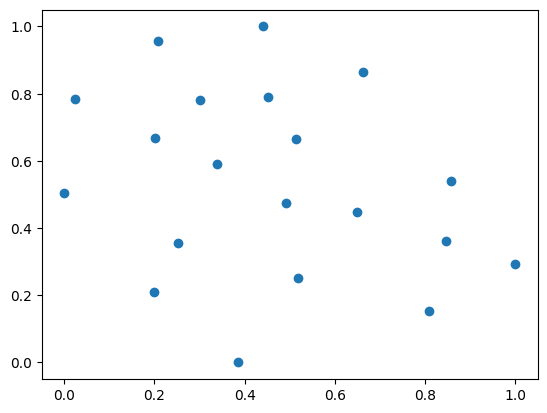

In [5]:
transposed = np.transpose(normalized)
plt.scatter(transposed[0], transposed[1])
plt.show()

## 5. Clustering (optional)

Next we could perform some clustering on this data using [K-Means](https://en.wikipedia.org/wiki/K-means_clustering). We won't be using this data for our visualisation, but it is something that could potentially be useful.

In [6]:
NUM_CLUSTERS = 3

kmeans = KMeans(n_clusters = NUM_CLUSTERS, random_state = 0, n_init = "auto")
clusters = kmeans.fit(normalized).labels_

# Create a random colour map for visualisation:
colour_map = {}
used = []
for item in clusters:
    if item not in used:
        colour_map[str(item)] = (random.random(), random.random(), random.random())
        used.append(item)

We can visualize the clusters in a scatter plot like this:

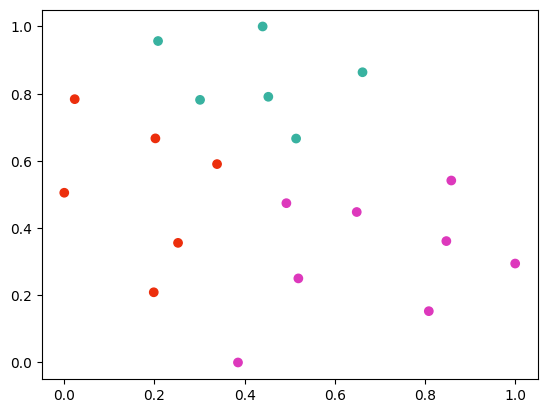

In [7]:
transposed = np.transpose(normalized)
col = []
for item in clusters:
    col.append(colour_map[str(item)])

plt.scatter(transposed[0], transposed[1], c = col)
plt.show()

We can save this data to a json file for future reference.

In [8]:
cluster_data = {}
for i, cluster in enumerate(clusters):
  cluster_data[manifest_list[i]] = {"cluster" : int(cluster)}

with open("cluster_data.json", 'w', encoding='utf-8') as f:
  json.dump(cluster_data, f, ensure_ascii = False, indent = 2)
files.download("cluster_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Visualization

Now we have all the data we need to create a visualization. We shall create a 2-dimensional image that places each of the images at their coordinates.

We shall be making two things:

*   The png image file
*   A list of rendered coordinates so that we can annotate the image later.

Let's create the image:

In [9]:
WIDTH = 10000
HEIGHT = 10000
PADDING = 1000
IMAGE_ZOOM = 0.25

def scale(val, old_min, old_max, new_min, new_max):
    return new_min + (((val - old_min) * (new_max - new_min)) / (old_max - old_min))

def add_image(full_image, coordinates_list, image_manifest, coordinates, idx):
  print(f"Adding image {image_manifest} ({idx + 1}/{len(normalized)})...")

  image_path = mfapi.read_manifest(image_manifest).get_media().id

  response = requests.get(image_path)
  img_data = BytesIO(response.content)

  this_img = Image.open(img_data)
  original_width, original_height = this_img.size

  w = int(original_width * IMAGE_ZOOM)
  h = int(original_height * IMAGE_ZOOM)
  x = int(scale(int(int(float(coordinates[0]) * WIDTH) - (w * 0.5)), 0, WIDTH, PADDING, WIDTH - (PADDING * 2)))
  y = int(scale(int(int(float(coordinates[1]) * HEIGHT) - (h * 0.5)), 0, HEIGHT, PADDING, HEIGHT - (PADDING * 2)))

  this_img = this_img.resize((w, h))
  full_image.paste(this_img, (x, y))

  coordinates_list.append({"file_name" : image_manifest, "x" : x, "y" : y, "w" : w, "h" : h})

full_image = Image.new('RGBA', (WIDTH, HEIGHT))
coordinates = {"images" : []}

for i, item in enumerate(normalized):
  add_image(full_image, coordinates["images"], manifest_list[i], item, i)

full_image.save("visualisation.png")
files.download("visualisation.png")

Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34898v.json (1/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34820v.json (2/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34865v.json (3/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34653v.json (4/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34978v.json (5/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34183v.json (6/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34552v.json (7/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a33879v.json (8/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a35207v.json (9/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34207v.json (10/20)...
Adding image https://files.tetras-libre.fr/manifests/fsa_color/1a34242v.json (11/20)...
Adding image https://files.tetras-libre.f

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This process can also be quite long, so let's save the coordinate data so that if anything bad happends we can start again from the next step.

In [11]:
with open("coordinate_data.json", 'w', encoding='utf-8') as f:
  json.dump(coordinates, f, ensure_ascii = False, indent = 2)
files.download("coordinate_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Export to Arvest

Finally, we can take this visualisation and the coordinate data and create an annotated IIIF Manifest from them that can be opened in Arvest and interacted with.

First, you need to make the image that was created available online - follow the Adding Media tutorial to do this. Once this is done, set the link to the image here, then create the basic Manifest around it:

In [12]:
image_url = "https://filebrowser.tetras-libre.fr/files/www/media/test/visualisation.png"

manifest = mfapi.Manifest(manifest_path = "manifests/my_manifests")
manifest.label = {"en" : ["Image Embedding T-SNE Projection"]}
manifest.add_canvas_from_media(image_url)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e484e7d5ee0>

Next, we create the annotations that will render the visualisation interactive:

In [ ]:
annotation_page = manifest.add_annotation_page()

for image in coordinates["images"]:
  annotation_page.add_annotation(
      link_to_manifest = image["file_name"],
      x = image["x"],
      y = image["y"],
      w = image["w"],
      h = image["h"],
      label = os.path.splitext(os.path.basename(image["file_name"]))[0]
  )

Now we can download the Manifest:

In [ ]:
files.download(manifest.to_json())

And clean up any temporary files!

In [ ]:
mfapi.clean_up()